<a href="https://colab.research.google.com/github/tsitsvero/rotor-gp/blob/main/pack/train_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [13]:
!pip install git+https://github.com/lab-cosmo/librascal gpytorch pytorch-lightning wandb git+https://github.com/chem-gp/fande xtb nbstripout
! nbstripout --install --global

  Cloning https://github.com/lab-cosmo/librascal to /tmp/pip-req-build-2wes6i41
  Running command git clone --filter=blob:none --quiet https://github.com/lab-cosmo/librascal /tmp/pip-req-build-2wes6i41
  Resolved https://github.com/lab-cosmo/librascal to commit 6c55e99720f9a181f1efc5c7cd4976c87809d79b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/chem-gp/fande to /tmp/pip-req-build-01vaygjh
  Running command git clone --filter=blob:none --quiet https://github.com/chem-gp/fande /tmp/pip-req-build-01vaygjh
  Resolved https://github.com/chem-gp/fande to commit aded96b5f6a1eec9b699457a47248bcb58f290d1
  Preparing metadata (setup.py) ... done


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cooking up the model

In [15]:
import os
# DATA_DIR = os.path.expanduser("~/repos/data/")
# # DATA_DIR = "/data1/simulations/datasets/rotors/high_temp_ML_training_data/"
# RESULTS_DIR = os.path.expanduser("~/repos/data/results")


DATA_DIR = os.path.expanduser("/content/drive/MyDrive/data/")
# FANDE_DIR = os.path.expanduser("~/")
RESULTS_DIR = os.path.expanduser("/content/results")
# os.makedirs(RESULTS_DIR, exist_ok=True)


ENERGY_MODEL = 'exact' #'variational_inducing_points', 'exact'
ENERGY_NUM_INDUCING_POINTS = 500
ENERGY_LR = 0.1
ENERGY_NUM_STEPS = 200

FORCES_MODEL = 'exact' #'variational_inducing_points', 'exact'
FORCES_NUM_INDUCING_POINTS = 500
NUM_FORCE_SAMPLES = 500
FORCES_LR = 0.1
FORCES_NUM_STEPS = 200

PREDICTOR_NAME = 'test.pth'
SUBSAMPLE = 2 # subsample data to reduce time durings tests

! python cook_model.py \
--data_dir $DATA_DIR \
--results_dir $RESULTS_DIR \
--energy_model $ENERGY_MODEL \
--energy_num_inducing_points $ENERGY_NUM_INDUCING_POINTS \
--energy_lr $ENERGY_LR \
--energy_num_steps $ENERGY_NUM_STEPS \
--forces_model $FORCES_MODEL \
--forces_num_inducing_points $FORCES_NUM_INDUCING_POINTS \
--num_force_samples $NUM_FORCE_SAMPLES \
--forces_lr $FORCES_LR \
--forces_num_steps $FORCES_NUM_STEPS \
--predictor_name $PREDICTOR_NAME \
--subsample $SUBSAMPLE


DATA_DIR /content/drive/MyDrive/data/
RESULTS_DIR /content/results
ENERGY_MODEL exact
ENERGY_NUM_INDUCING_POINTS 500
ENERGY_LR 0.1
ENERGY_NUM_STEPS 200
FORCES_MODEL exact
FORCES_NUM_INDUCING_POINTS 500
NUM_FORCE_SAMPLES 500
FORCES_LR 0.1
FORCES_NUM_STEPS 200
PREDICTOR_NAME test.pth
500 500
fande.models module imported...
Icecream logger is not available
Total number of found groups: 14
Checking if all atoms are covered:  True
Total length of traj is 500
Total number of batches 500
Calculating invariants on trajectory with librascal...
100% 500/500 [00:15<00:00, 32.35it/s]
invariants for energy fitting calculated
100% 500/500 [08:19<00:00,  1.00it/s]
invariants for forces fitting calculated
torch.Size([500, 1200])
torch.Size([500])
Dataloader for group 0 created
Number of samples in dataloader: 500
Dataloader for group 1 created
Number of samples in dataloader: 500
Dataloader for group 2 created
Number of samples in dataloader: 500
Dataloader for group 3 created
Number of samples in dat

## Testing models

In [16]:
from ase import io
test_traj = io.read(DATA_DIR + "/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="1000:1010")

In [17]:
import sys
import torch
FANDE_DIR = os.path.expanduser("~/repos/")
sys.path.append(FANDE_DIR + "fande/")

from fande.predict import FandePredictor
from fande.ase import FandeCalc
# load the predictor:
# predictor_loaded = torch.load(RESULTS_DIR + "/fande_predictor.pth")
predictor_loaded = torch.load(RESULTS_DIR + "/test.pth")
fande_calc_loaded = FandeCalc(predictor_loaded)
device = torch.device('cpu')
fande_calc_loaded.predictor.move_models_to_device(device)

In [18]:
forces_true = []
forces_predicted = []

energy_true = []
energy_predicted = []

for atoms in test_traj:
    forces_true.append(atoms.get_forces())
    energy_true.append(atoms.get_potential_energy())
    atoms.set_calculator(fande_calc_loaded)
    forces_predicted.append(atoms.get_forces())
    energy_predicted.append(atoms.get_potential_energy())

INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1163.330316543579
Predicting forces...


INFO:fande:Setting context for descriptors calculation to production


Energy model summary: 
Time invariants:  0.19598007202148438
Time prediction:  105.66282272338867
Time moving on device:  0.16570091247558594
Time total:  121.44041061401367


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  2864.177703857422
Predicting forces...
Energy model summary: 
Time invariants:  0.14781951904296875
Time prediction:  22.264719009399414
Time moving on device:  0.21314620971679688
Time total:  34.05570983886719


INFO:fande:Setting context for descriptors calculation to production
INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1111.2167835235596
Predicting forces...
Energy model summary: 
Time invariants:  0.20003318786621094
Time prediction:  87.96954154968262
Time moving on device:  0.4878044128417969
Time total:  103.12414169311523
Time for invariants (call from forces):  1572.5500583648682
Predicting forces...
Energy model summary: 
Time invariants:  0.14519691467285156
Time prediction:  3.6172866821289062
Time moving on device:  0.2219676971435547
Time total:  16.18671417236328


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1552.8488159179688
Predicting forces...
Energy model summary: 
Time invariants:  0.14781951904296875
Time prediction:  3.315448760986328
Time moving on device:  0.2276897430419922
Time total:  11.557340621948242


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1166.8040752410889
Predicting forces...
Energy model summary: 
Time invariants:  0.17833709716796875
Time prediction:  18.036842346191406
Time moving on device:  0.7805824279785156
Time total:  34.4240665435791


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1186.7361068725586
Predicting forces...
Energy model summary: 
Time invariants:  0.2071857452392578
Time prediction:  93.28341484069824
Time moving on device:  0.2703666687011719
Time total:  111.24038696289062


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1166.7373180389404
Predicting forces...
Energy model summary: 
Time invariants:  0.1399517059326172
Time prediction:  3.816366195678711
Time moving on device:  0.2148151397705078
Time total:  9.114265441894531


INFO:fande:Setting context for descriptors calculation to production


Time for invariants (call from forces):  1191.166877746582
Predicting forces...
Energy model summary: 
Time invariants:  0.17905235290527344
Time prediction:  80.22022247314453
Time moving on device:  0.2923011779785156
Time total:  94.82574462890625
Time for invariants (call from forces):  1110.992670059204
Predicting forces...
Energy model summary: 
Time invariants:  0.17881393432617188
Time prediction:  3.1549930572509766
Time moving on device:  0.17762184143066406
Time total:  11.147737503051758


Atomic group [0, 1, 2, 3, 4, 5, 264, 265, 266, 267, 268, 269]
F_x
MAE 0.3027110040818685
RMSE 0.34323150844765443
F_y
MAE 0.2646667866483968
RMSE 0.334958930566546
F_z
MAE 0.2661868950483398
RMSE 0.33154227143182247
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


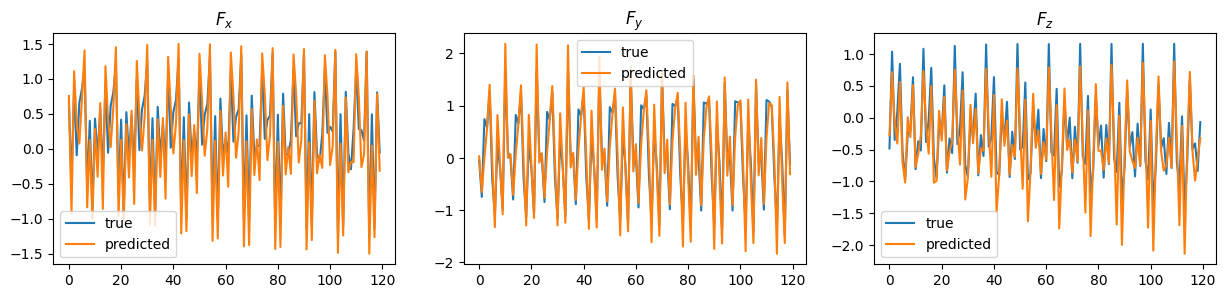

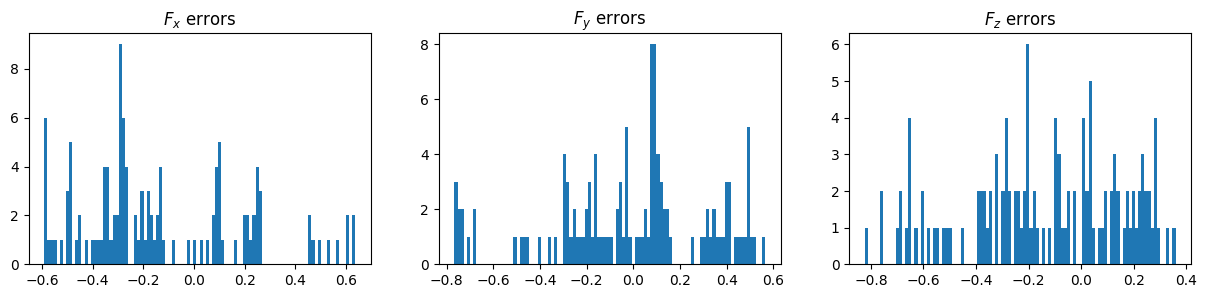

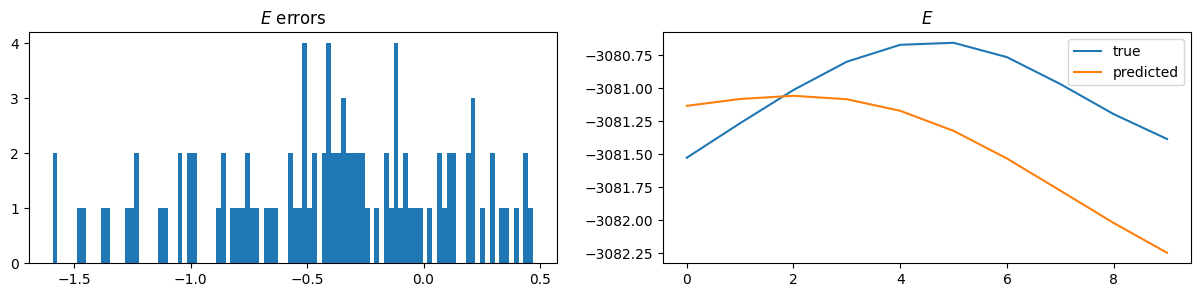

Atomic group [146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 5

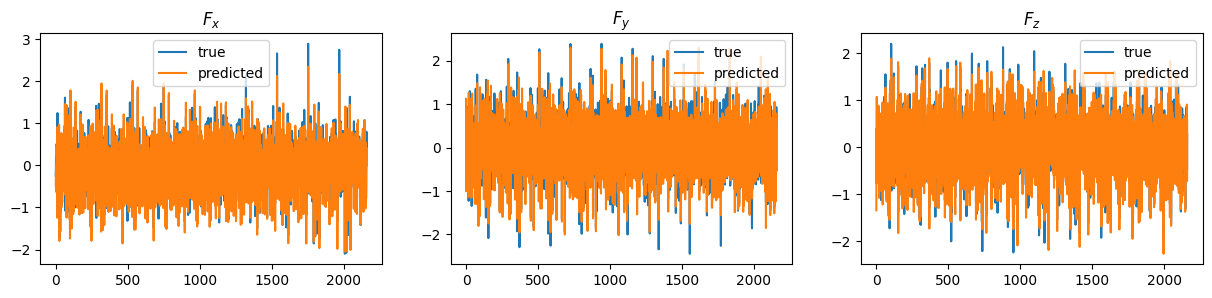

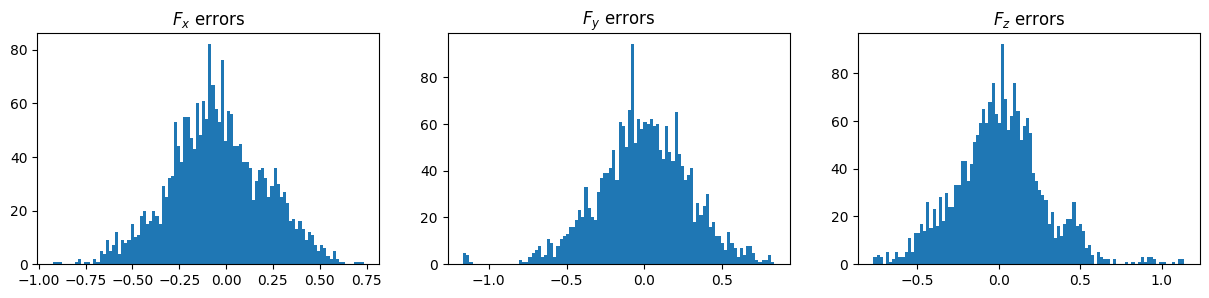

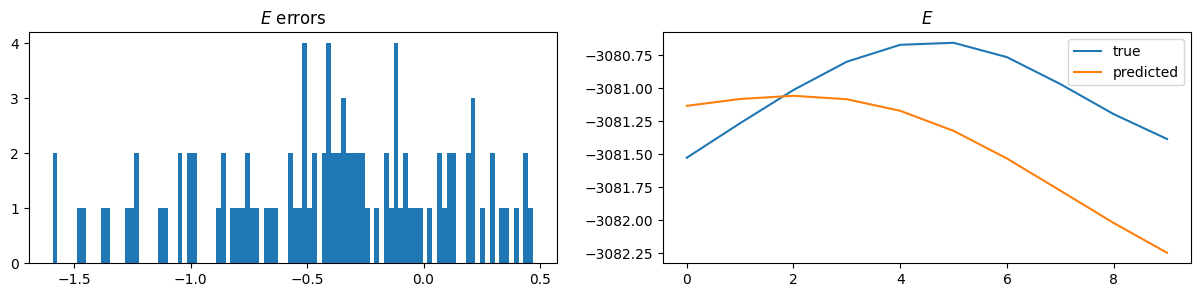

Atomic group [56, 57, 58, 59, 60, 61, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 98, 99, 100, 101, 320, 321, 322, 323, 324, 325, 330, 331, 332, 333, 334, 335, 336, 337, 340, 341, 342, 343, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 362, 363, 364, 365]
F_x
MAE 0.3369075181053603
RMSE 0.4311109901348178
F_y
MAE 0.38758438692312275
RMSE 0.4836586815486217
F_z
MAE 0.34912515901150853
RMSE 0.45655537480445213
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


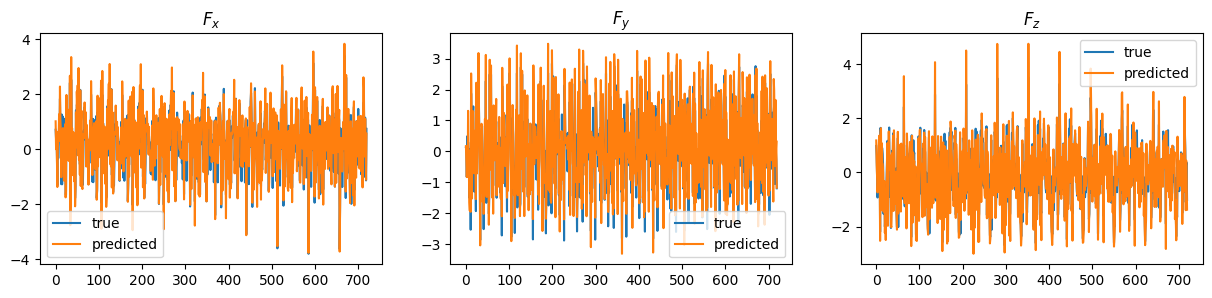

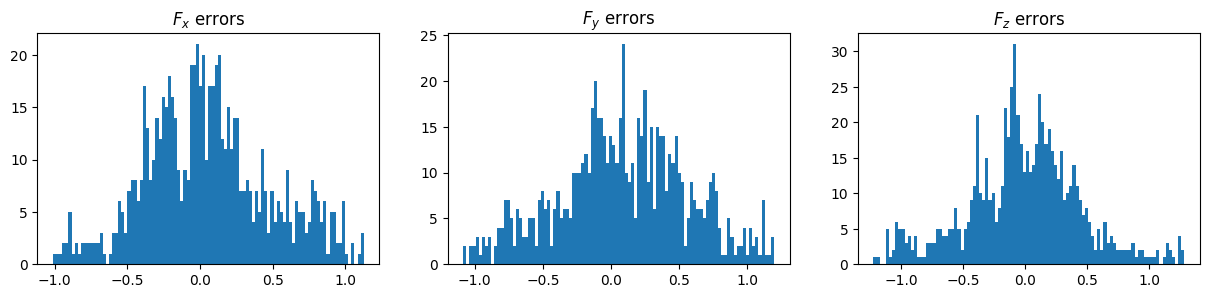

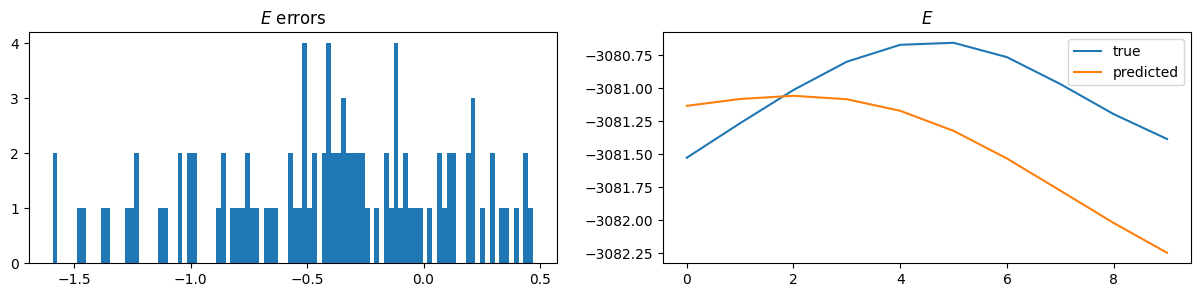

Atomic group [108, 109, 110, 111, 112, 113, 372, 373, 374, 375, 376, 377]
F_x
MAE 0.14399042807991538
RMSE 0.1673805468192112
F_y
MAE 0.2194084693761393
RMSE 0.27279473872073295
F_z
MAE 0.2578504381077474
RMSE 0.2947904776401143
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


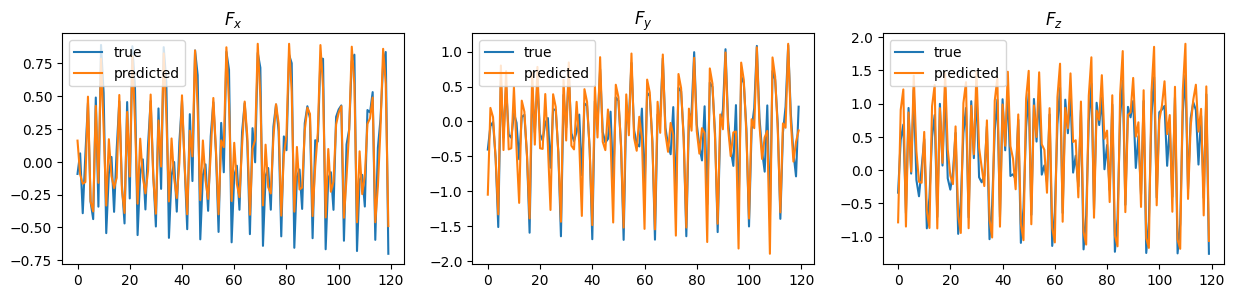

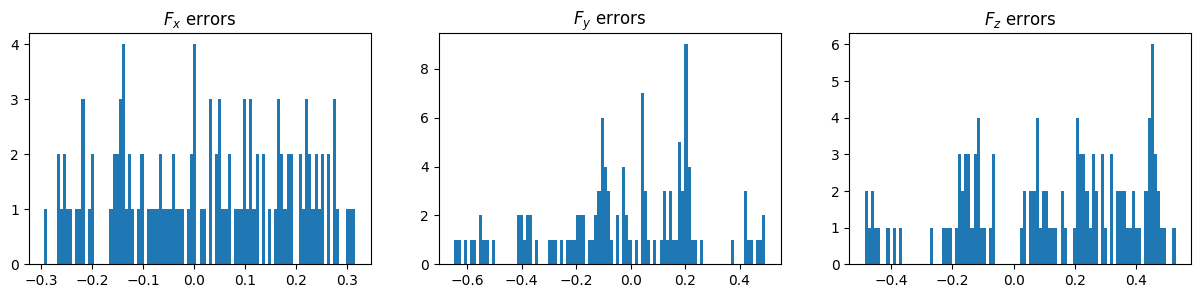

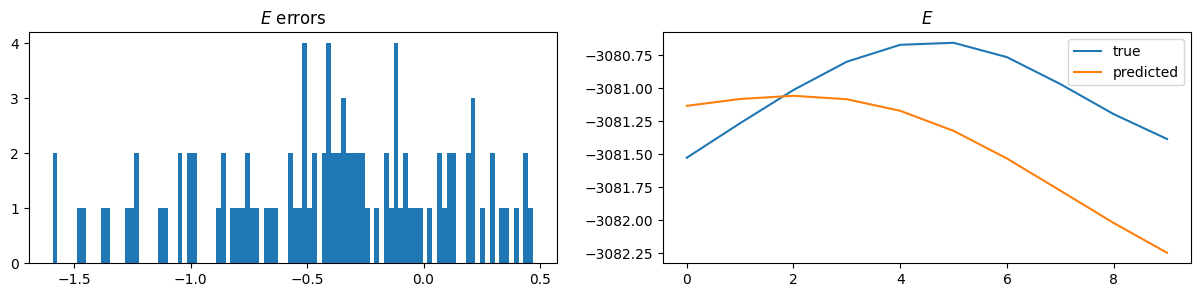

Atomic group [6, 7, 8, 9, 10, 11, 270, 271, 272, 273, 274, 275]
F_x
MAE 0.1538015321588542
RMSE 0.1913283884330329
F_y
MAE 0.26230479596394857
RMSE 0.3281383813815005
F_z
MAE 0.17866239029600015
RMSE 0.21759919904182906
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


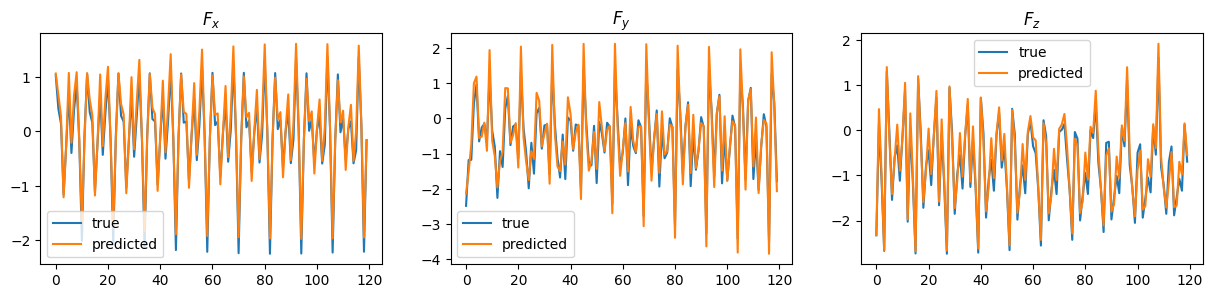

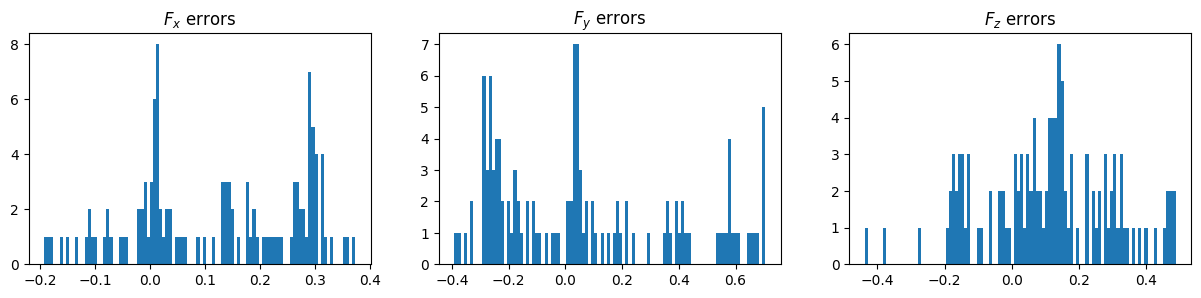

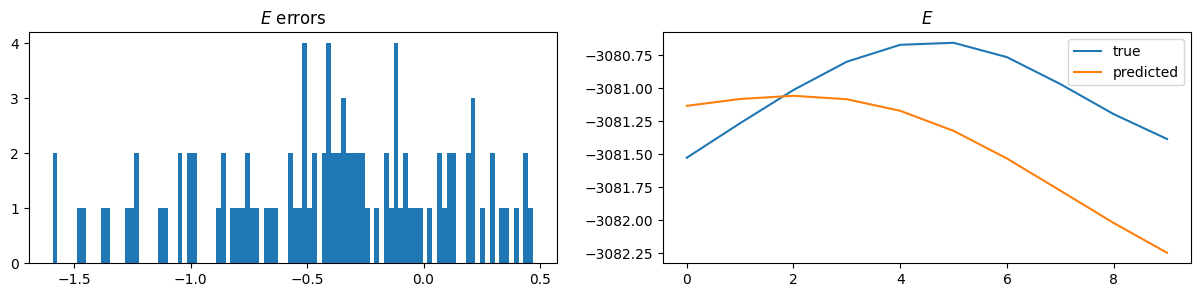

Atomic group [116, 117, 118, 119, 122, 123, 124, 125, 134, 135, 136, 137, 380, 381, 382, 383, 386, 387, 388, 389, 398, 399, 400, 401]
F_x
MAE 0.1539533595970052
RMSE 0.19902752099100615
F_y
MAE 0.129742956930013
RMSE 0.16125736838837698
F_z
MAE 0.12408235370393879
RMSE 0.15476136958528133
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


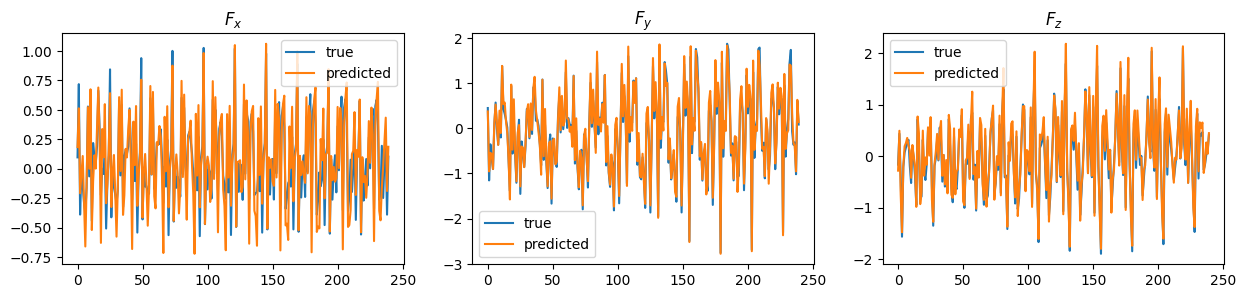

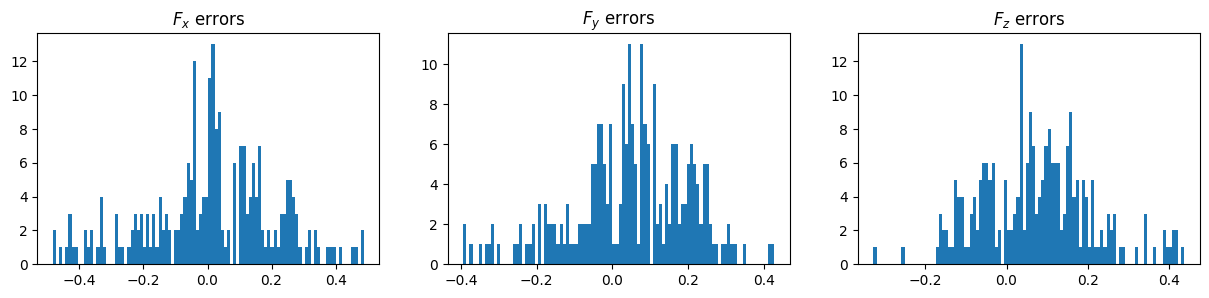

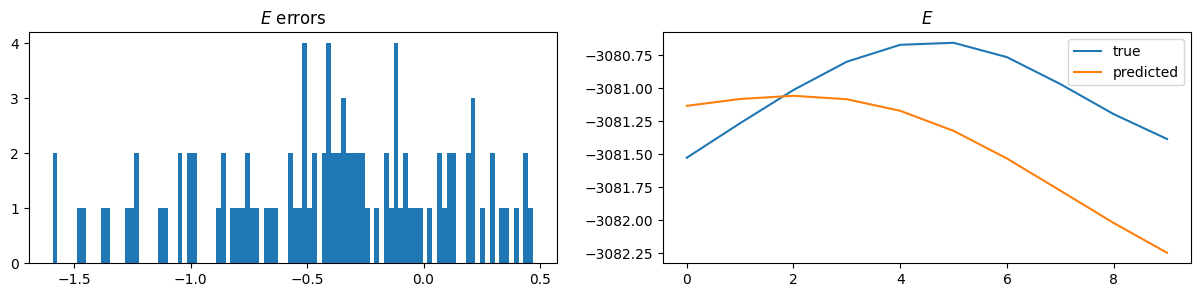

Atomic group [36, 37, 50, 51, 52, 53, 54, 55, 62, 63, 64, 65, 74, 75, 80, 81, 96, 97, 300, 301, 314, 315, 316, 317, 318, 319, 326, 327, 328, 329, 338, 339, 344, 345, 360, 361]
F_x
MAE 0.2872786656156006
RMSE 0.3634362965816134
F_y
MAE 0.2801576204950494
RMSE 0.32695569530635993
F_z
MAE 0.289091271542711
RMSE 0.35768849347124343
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


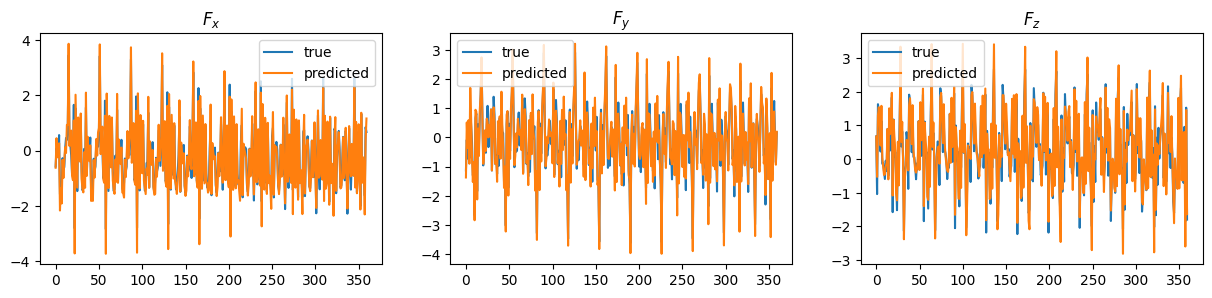

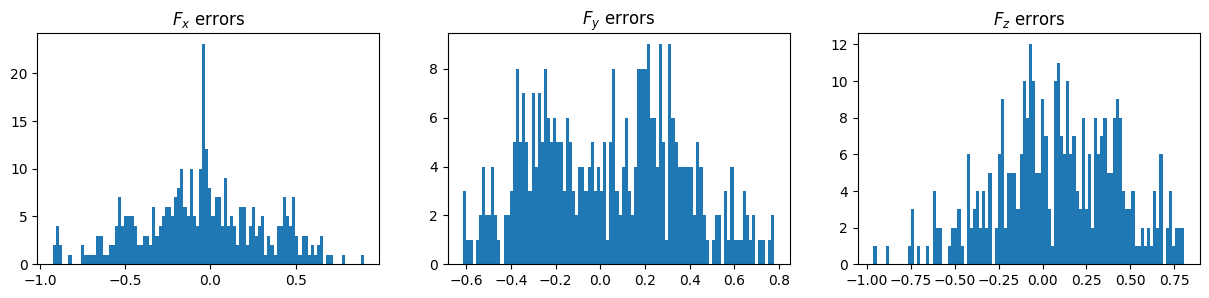

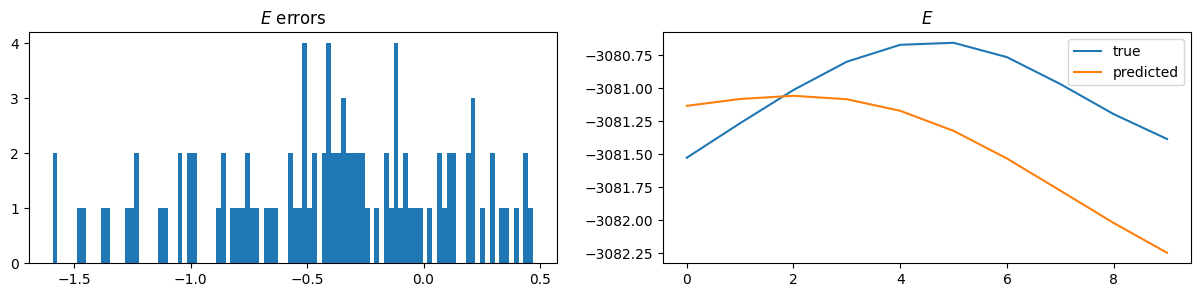

Atomic group [114, 115, 120, 121, 126, 127, 128, 129, 132, 133, 138, 139, 378, 379, 384, 385, 390, 391, 392, 393, 396, 397, 402, 403]
F_x
MAE 0.14777743261855064
RMSE 0.17855943265694724
F_y
MAE 0.12024080156758626
RMSE 0.16502495297580735
F_z
MAE 0.13959978153993735
RMSE 0.17795272196614373
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


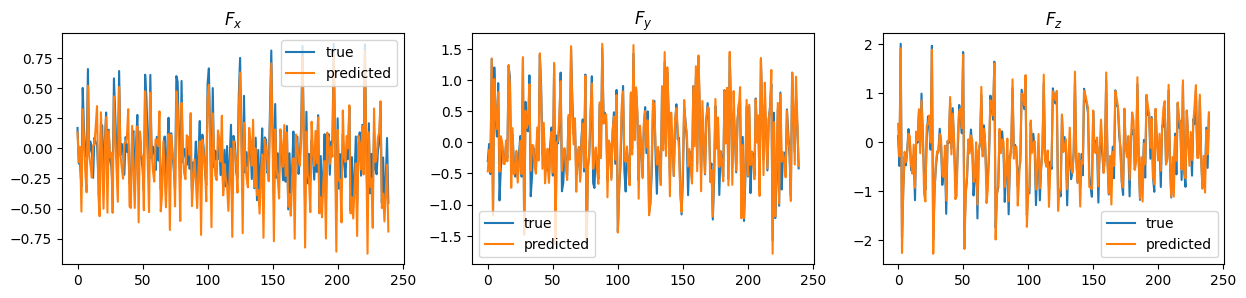

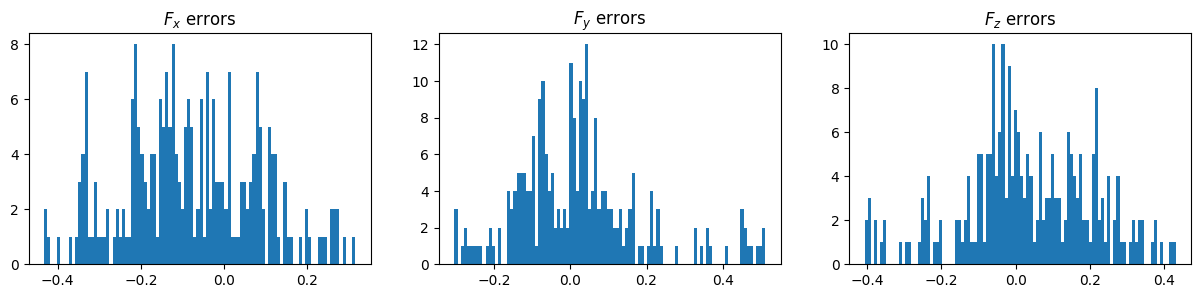

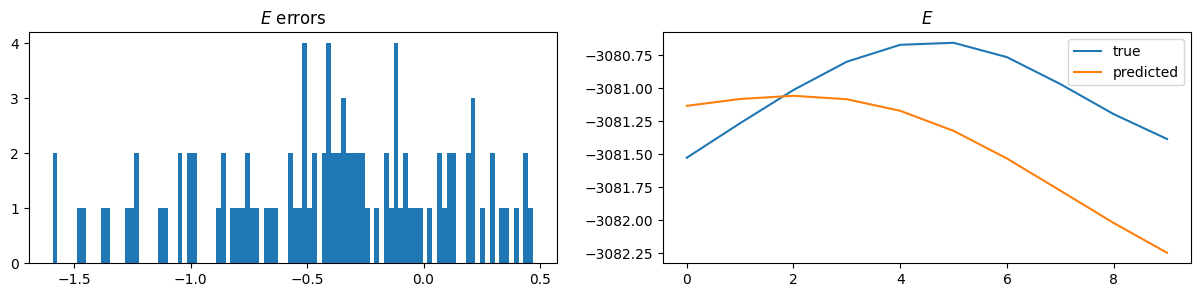

Atomic group [16, 17, 20, 21, 24, 25, 28, 29, 42, 43, 46, 47, 280, 281, 284, 285, 288, 289, 292, 293, 306, 307, 310, 311]
F_x
MAE 0.24275205343505857
RMSE 0.3277996426449896
F_y
MAE 0.24902787418717448
RMSE 0.3157357835968055
F_z
MAE 0.2824575085405273
RMSE 0.33666147089641135
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


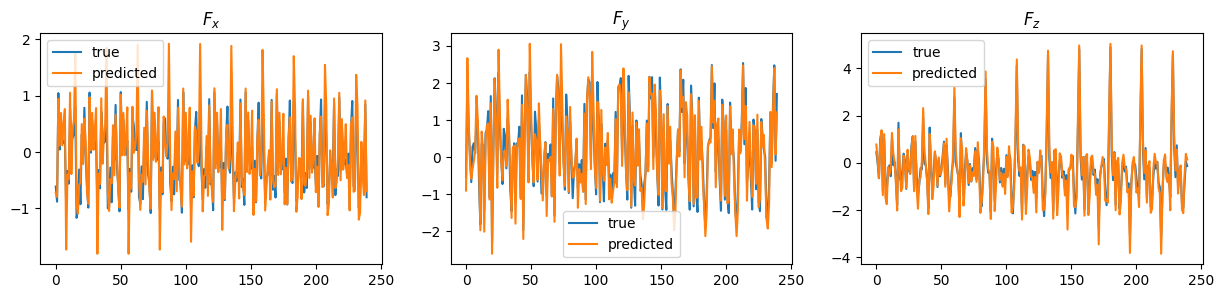

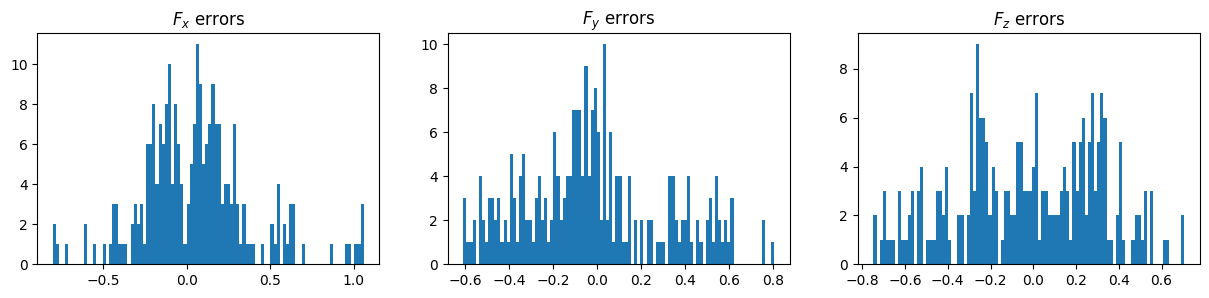

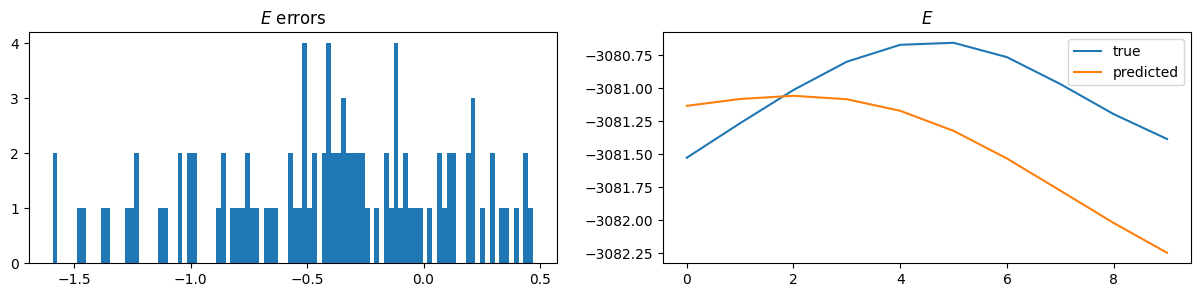

Atomic group [130, 131, 140, 141, 142, 143, 144, 145, 164, 165, 166, 167, 192, 193, 206, 207, 250, 251, 394, 395, 404, 405, 406, 407, 408, 409, 428, 429, 430, 431, 456, 457, 470, 471, 514, 515]
F_x
MAE 0.1761763628557943
RMSE 0.21628032100496777
F_y
MAE 0.12940515039057074
RMSE 0.16258614647541794
F_z
MAE 0.14198716177023654
RMSE 0.18066463519553647
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


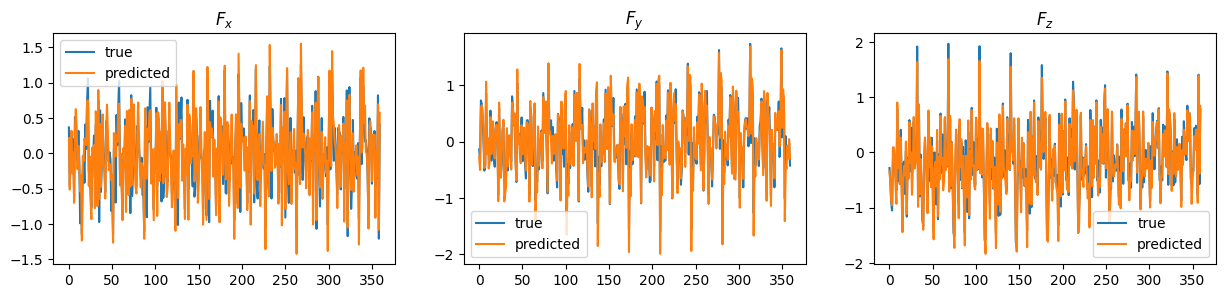

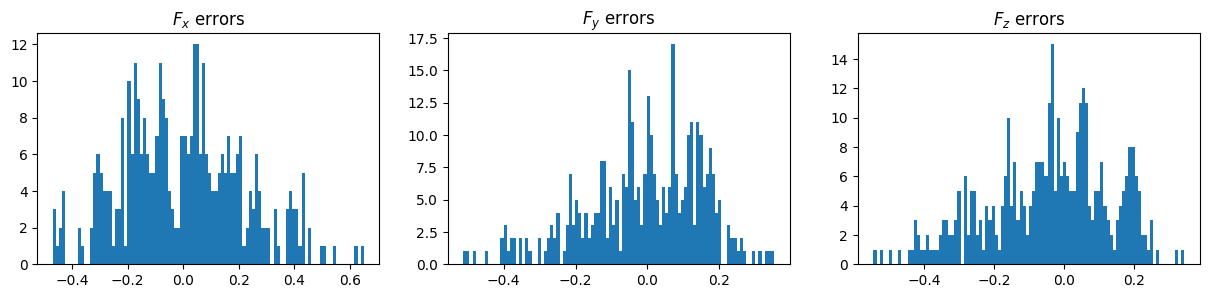

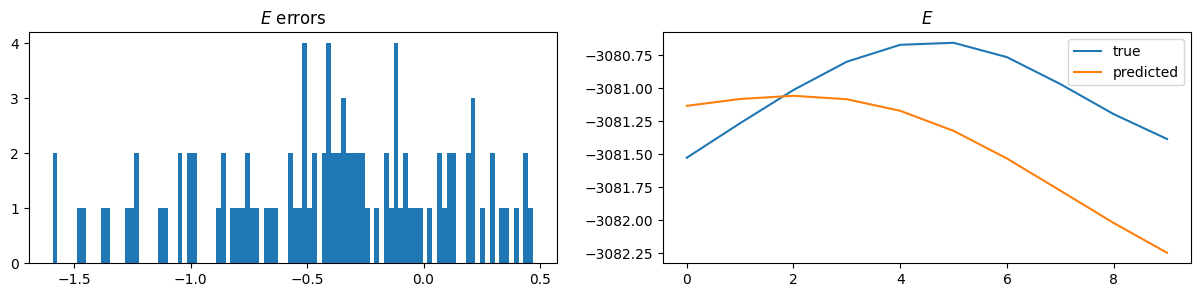

Atomic group [18, 19, 26, 27, 44, 45, 282, 283, 290, 291, 308, 309]
F_x
MAE 0.16248017854329427
RMSE 0.2007139155349053
F_y
MAE 0.2664199875913086
RMSE 0.33227571435833103
F_z
MAE 0.21309071205794272
RMSE 0.2920668406266833
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


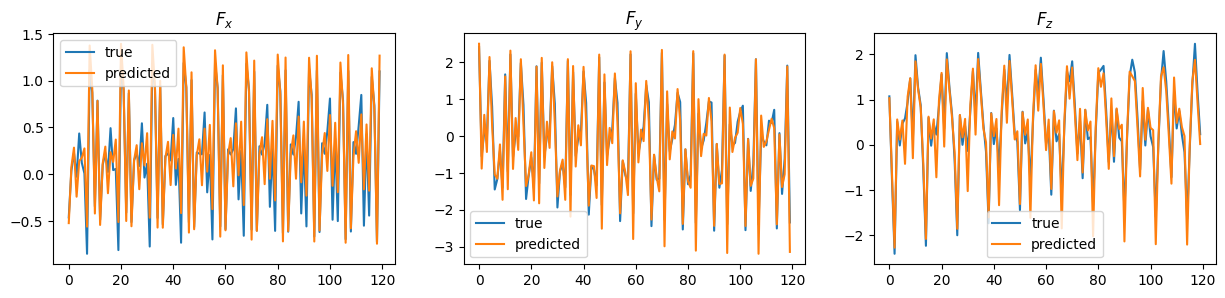

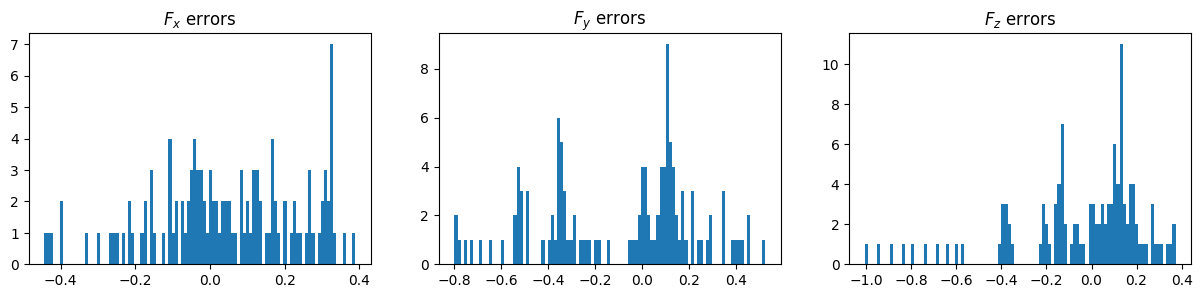

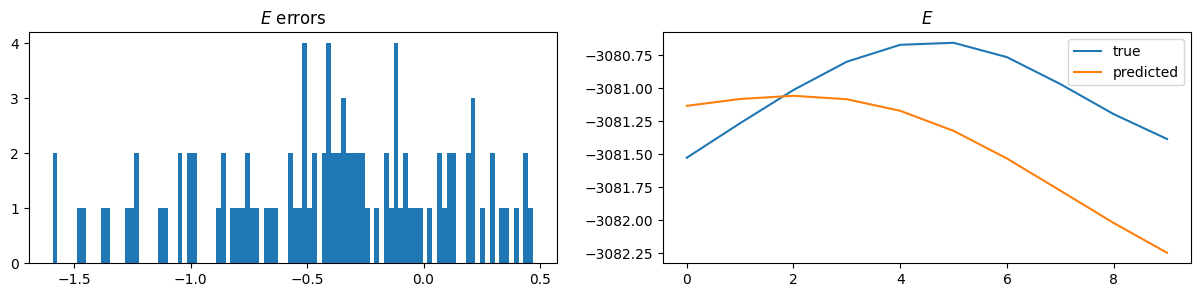

Atomic group [14, 15, 22, 23, 30, 31, 34, 35, 40, 41, 48, 49, 278, 279, 286, 287, 294, 295, 298, 299, 304, 305, 312, 313]
F_x
MAE 0.17647592659595743
RMSE 0.24207286801319855
F_y
MAE 0.2987843957856242
RMSE 0.38582897223108226
F_z
MAE 0.37741211435652666
RMSE 0.45668192636986915
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


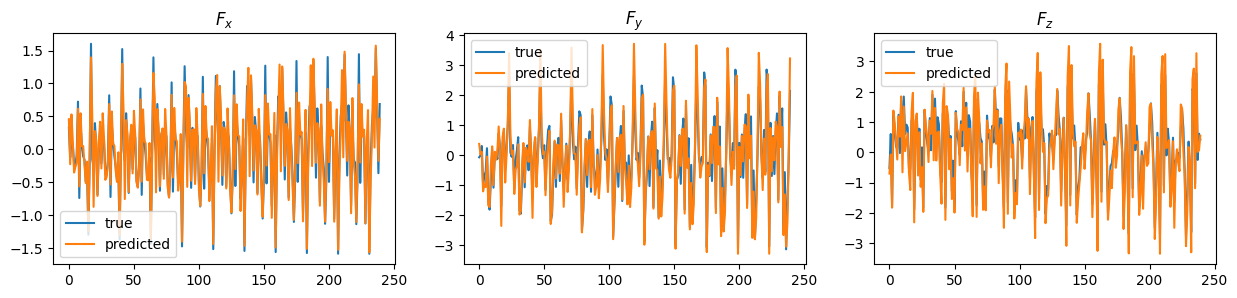

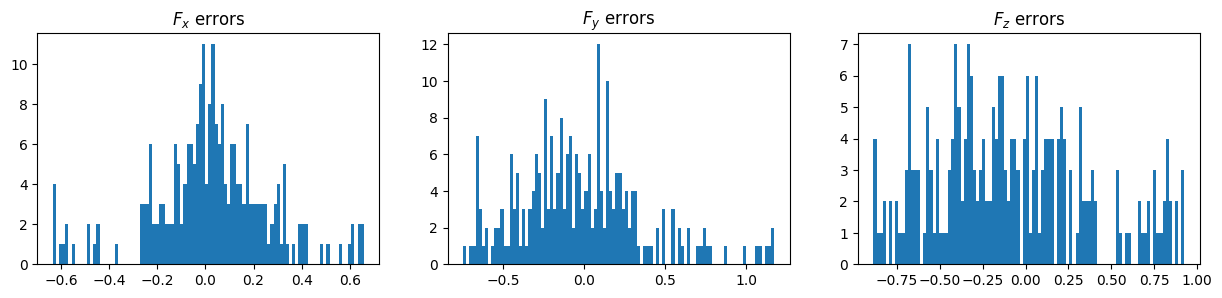

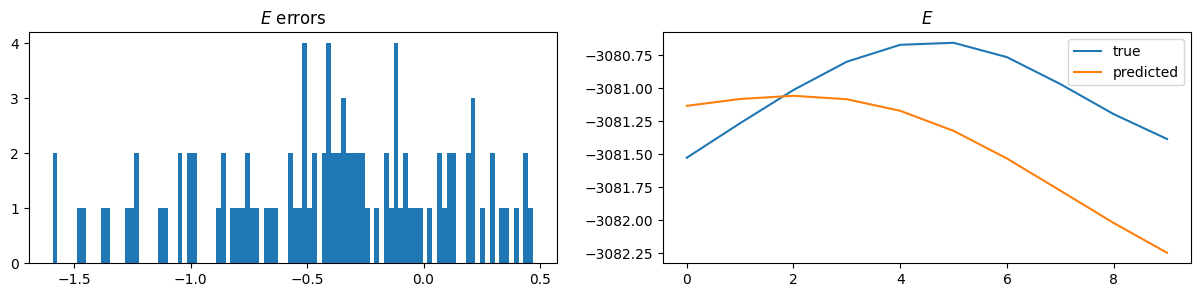

Atomic group [12, 13, 32, 33, 38, 39, 276, 277, 296, 297, 302, 303]
F_x
MAE 0.22086529399161783
RMSE 0.26927053679316343
F_y
MAE 0.13668789277447507
RMSE 0.1819703751036129
F_z
MAE 0.2004512275997416
RMSE 0.272734397059469
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


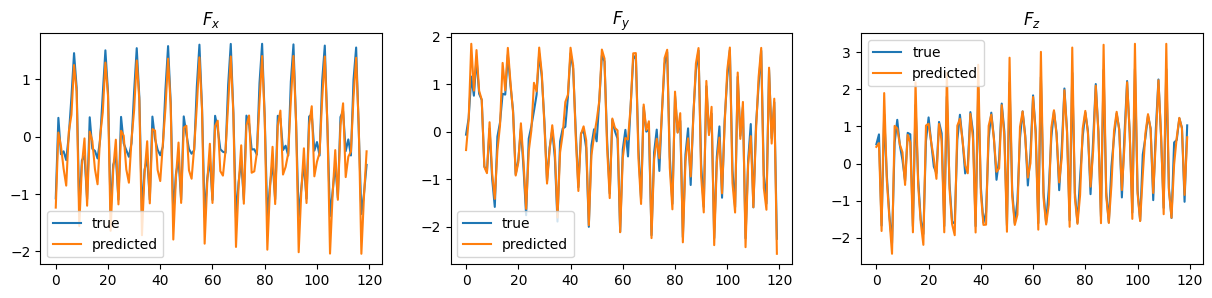

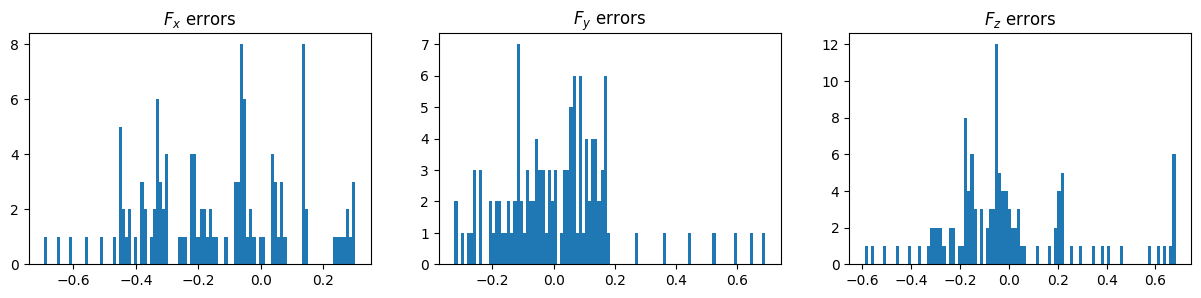

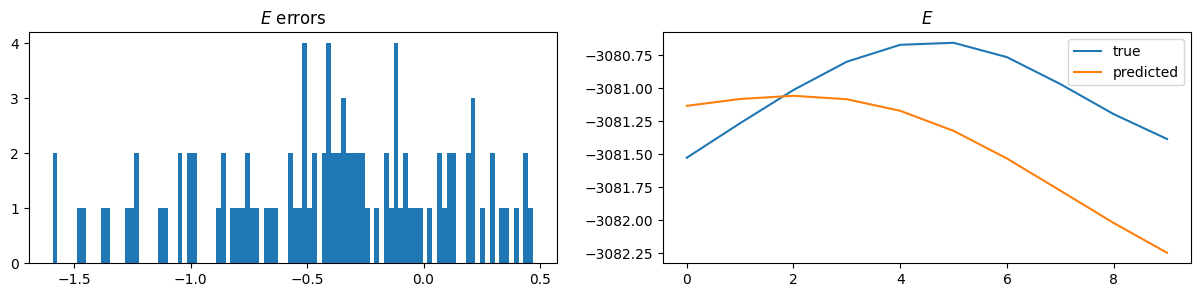

Atomic group [102, 103, 104, 105, 106, 107, 366, 367, 368, 369, 370, 371]
F_x
MAE 0.2285790132043864
RMSE 0.26578676714165456
F_y
MAE 0.2416030144849243
RMSE 0.32097077050165884
F_z
MAE 0.239738212271993
RMSE 0.2980053091679705
E
MAE 0.5190463479875143
RMSE 0.6557416159194458


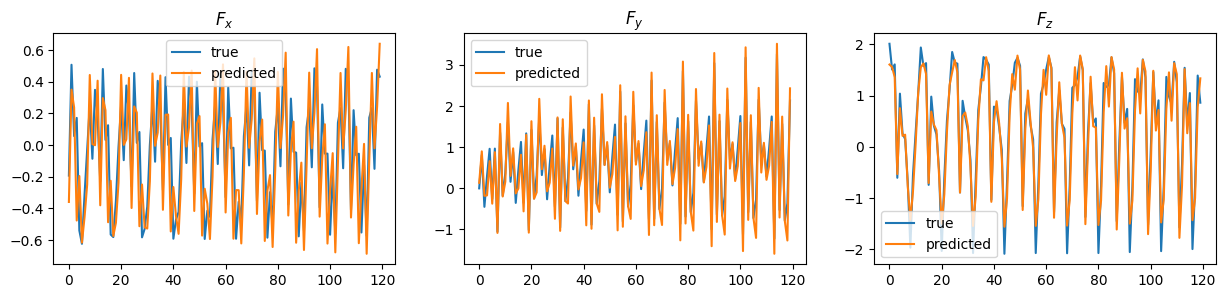

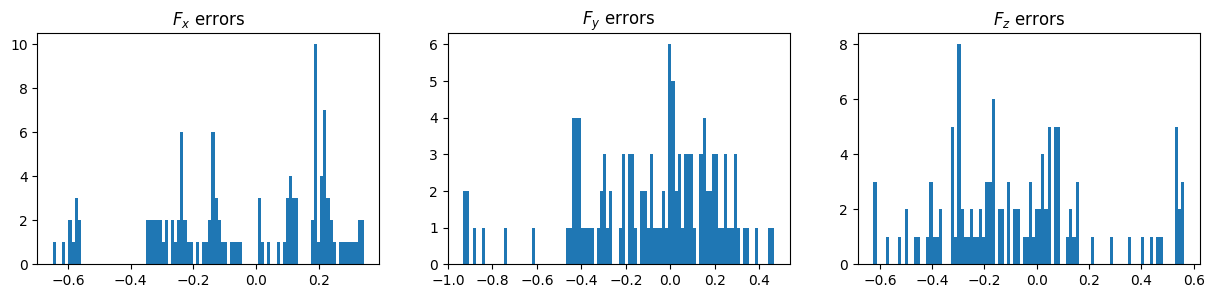

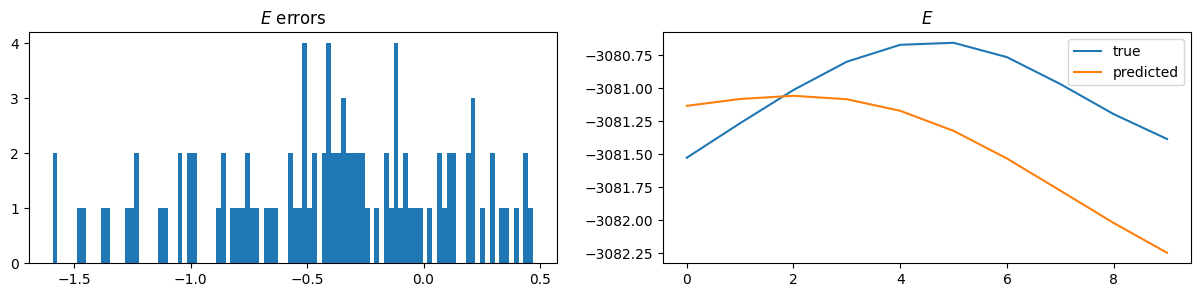

In [19]:
import numpy as np
import matplotlib.pyplot as plt

energy_true = np.array(energy_true)
energy_predicted = np.array(energy_predicted)
energy_errors = energy_predicted - energy_true

forces_true = np.array(forces_true)
forces_predicted = np.array(forces_predicted)
forces_errors = forces_predicted - forces_true

atomic_groups = predictor_loaded.fdm.atomic_groups



for ag in atomic_groups:

    print("Atomic group", ag)
    print("F_x")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 0].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 0].flatten()**2)))
    print("F_y")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 1].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 1].flatten()**2)))
    print("F_z")
    print("MAE", np.mean(np.abs(forces_errors[:, ag, 2].flatten())))
    print("RMSE", np.sqrt(np.mean(forces_errors[:, ag, 2].flatten()**2)))
    print("E")
    print("MAE", np.mean(np.abs(energy_errors.flatten())))
    print("RMSE", np.sqrt(np.mean(energy_errors.flatten()**2)))

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
    axs[0].set_title(r"$F_x$")
    axs[0].plot(np.array(forces_true)[:, ag, 0].flatten(), label="true")
    axs[0].plot(np.array(forces_predicted)[:, ag, 0].flatten(), label="predicted")
    axs[0].legend()

    axs[1].set_title(r"$F_y$")
    axs[1].plot(np.array(forces_true)[:, ag, 1].flatten(), label="true")
    axs[1].plot(np.array(forces_predicted)[:, ag, 1].flatten(), label="predicted")
    axs[1].legend()

    axs[2].set_title(r"$F_z$")
    axs[2].plot(np.array(forces_true)[:, ag, 2].flatten(), label="true")
    axs[2].plot(np.array(forces_predicted)[:, ag, 2].flatten(), label="predicted")
    axs[2].legend()

    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

    axs[0].set_title(r"$F_x$ errors")
    axs[0].hist(forces_errors[:, ag, 0].flatten(), bins=100)

    axs[1].set_title(r"$F_y$ errors")
    axs[1].hist(forces_errors[:, ag, 1].flatten(), bins=100)

    axs[2].set_title(r"$F_z$ errors")
    axs[2].hist(forces_errors[:, ag, 2].flatten(), bins=100)
    plt.show()

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    axs[0].set_title(r"$E$ errors")
    axs[0].hist(energy_errors.flatten(), bins=100)

    axs[1].set_title(r"$E$")
    axs[1].plot(energy_true, label="true")
    axs[1].plot(energy_predicted, label="predicted")
    axs[1].legend()
    plt.show()
